In [1]:
# !pip install -U pandasql 

# Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
% pylab inline 
from pandasql import sqldf
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('purchases.txt', sep="\t", header = None)
data.columns = ["customer_id", "purchase_amount", "date_of_purchase"]

In [4]:
data.head()

,customer_id,purchase_amount,date_of_purchase
0,760,25.0,2009-11-06
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-07-09
4,1940,70.0,2013-01-25


In [5]:
max(data['date_of_purchase'])

'2015-12-31'

In [6]:
data = data.sort(columns = ["customer_id", "date_of_purchase"])

/Users/Charlotte/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [7]:
data['date_of_purchase'] = pd.to_datetime(data['date_of_purchase'])

In [8]:
data['month_purchase'] = data['date_of_purchase'].apply(lambda x: x.month)

In [9]:
data['year_purchase'] = data['date_of_purchase'].apply(lambda x: x.year)

In [10]:
data['year_of_purchase'] = pd.DatetimeIndex(data['date_of_purchase']).year
data['days_since'] = (pd.Timestamp('2016-01-01') - data['date_of_purchase']).dt.days

In [11]:
data.head()

,customer_id,purchase_amount,date_of_purchase,month_purchase,year_purchase,year_of_purchase,days_since
46421,10,30.0,2005-07-08,7,2005,2005,3829
40141,80,50.0,2005-09-24,9,2005,2005,3751
15624,80,60.0,2007-04-18,4,2007,2007,3180
46422,80,70.0,2009-04-10,4,2009,2009,2457
11457,80,80.0,2011-08-05,8,2011,2011,1610


# Segmentation

In [12]:
# Segment customers in 2015
customers_2015 = sqldf("SELECT customer_id, MIN(days_since) AS 'recency', MAX(days_since) AS 'first_purchase', COUNT(*) AS 'frequency', AVG(purchase_amount) AS 'amount' FROM data GROUP BY 1", globals())

customers_2015['segment']=np.empty(len(customers_2015), dtype=object)
customers_2015.segment.loc[customers_2015.recency>3*365] = 'inactive'
customers_2015.segment.loc[(customers_2015.recency<=3*365) & (customers_2015.recency>2*365)] = 'cold'
customers_2015.segment.loc[(customers_2015.recency<=2*365) & (customers_2015.recency>1*365)] = 'warm'
customers_2015.segment.loc[customers_2015.recency<1*365] = 'active'
customers_2015.segment.loc[(customers_2015.segment=='warm') & (customers_2015.amount<100)] = 'warm low value'
customers_2015.segment.loc[(customers_2015.segment=='warm') & (customers_2015.amount>=100)] = 'warm high value'
customers_2015.segment.loc[(customers_2015.segment=='active') & (customers_2015.amount<100)] = 'active low value'
customers_2015.segment.loc[(customers_2015.segment=='active') & (customers_2015.amount>=100)] = 'active high value'

# customers_2015.segment = customers_2015.segment.astype('category').cat.reorder_categories(['inactive', 'cold', 'warm', 'active','warm high value', 'warm low value', 'active high value', 'active low value'], ordered=True)

/Users/Charlotte/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
import collections

In [14]:
# notice that we dont have 'warm' and 'new cold'
segment_2015 = Counter(customers_2015['segment'])
segment_2015 = collections.OrderedDict(sorted(segment_2015.items()))
df_segment_2015 = pd.DataFrame(list(segment_2015.items()))
df_segment_2015.columns = ['segment','count']

df_segment_2015

,segment,count
0,active high value,836
1,active low value,4562
2,cold,1903
3,inactive,9158
4,warm high value,235
5,warm low value,1723


In [15]:
customers_2015.head()

,customer_id,recency,first_purchase,frequency,amount,segment
0,10,3829,3829,1,30.000000,inactive
1,80,343,3751,7,71.428571,active low value
2,90,758,3783,10,115.800000,cold
3,120,1401,1401,1,20.000000,inactive
4,130,2970,3710,2,50.000000,inactive


In [16]:
# Segment customers in 2014
customers_2014 = sqldf("SELECT customer_id, MIN(days_since) - 365 AS 'recency', MAX(days_since) - 365 AS 'first_purchase', COUNT(*) AS 'frequency', AVG(purchase_amount) AS 'amount' FROM data WHERE days_since > 365 GROUP BY 1", globals())

customers_2014['segment']=np.empty(len(customers_2014), dtype=object)
customers_2014.segment.loc[customers_2014.recency>3*365] = 'inactive'
customers_2014.segment.loc[(customers_2014.recency<=3*365) & (customers_2014.recency>2*365)] = 'cold'
customers_2014.segment.loc[(customers_2014.recency<=2*365) & (customers_2014.recency>1*365)] = 'warm'
customers_2014.segment.loc[customers_2014.recency<1*365] = 'active'
customers_2014.segment.loc[(customers_2014.segment=='warm') & (customers_2014.amount<100)] = 'warm low value'
customers_2014.segment.loc[(customers_2014.segment=='warm') & (customers_2014.amount>=100)] = 'warm high value'
customers_2014.segment.loc[(customers_2014.segment=='active') & (customers_2014.amount<100)] = 'active low value'
customers_2014.segment.loc[(customers_2014.segment=='active') & (customers_2014.amount>=100)] = 'active high value'

# customers_2014.segment = customers_2014.segment.astype('category').cat.reorder_categories(['inactive', 'cold', 'warm high value', 'warm low value', 'new warm', 'active high value', 'active low value', 'new active'], ordered=True)



/Users/Charlotte/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
customers_2014.head()

,customer_id,recency,first_purchase,frequency,amount,segment
0,10,3464,3464,1,30.0,inactive
1,80,302,3386,6,70.0,active low value
2,90,393,3418,10,115.8,warm high value
3,120,1036,1036,1,20.0,cold
4,130,2605,3345,2,50.0,inactive


In [18]:
segment_2014 = Counter(customers_2014['segment'])
segment_2014 =collections.OrderedDict(sorted(segment_2014.items()))
df_segment_2014 = pd.DataFrame(list(segment_2014.items()))
df_segment_2014.columns = ['segment','count']

df_segment_2014

,segment,count
0,active high value,678
1,active low value,4245
2,cold,2153
3,inactive,7512
4,warm high value,238
5,warm low value,2079


# Transition Matrix

In [19]:
# Compute transition matrix
new_data = pd.merge(customers_2014, customers_2015, on='customer_id', how='left')
new_data.head()

,customer_id,recency_x,first_purchase_x,frequency_x,amount_x,segment_x,recency_y,first_purchase_y,frequency_y,amount_y,segment_y
0,10,3464,3464,1,30.0,inactive,3829,3829,1,30.000000,inactive
1,80,302,3386,6,70.0,active low value,343,3751,7,71.428571,active low value
2,90,393,3418,10,115.8,warm high value,758,3783,10,115.800000,cold
3,120,1036,1036,1,20.0,cold,1401,1401,1,20.000000,inactive
4,130,2605,3345,2,50.0,inactive,2970,3710,2,50.000000,inactive


In [20]:
transition = pd.crosstab(new_data.segment_x, new_data.segment_y)
transition

segment_y,active high value,active low value,cold,inactive,warm high value,warm low value
segment_x,,,,,,
active high value,436,7,0,0,235,0
active low value,29,2493,0,0,0,1723
cold,22,200,0,1931,0,0
inactive,35,250,0,7227,0,0
warm high value,50,1,187,0,0,0
warm low value,1,362,1716,0,0,0


In [21]:
transition = transition.apply(lambda r: r/r.sum(), axis=1)
transition

segment_y,active high value,active low value,cold,inactive,warm high value,warm low value
segment_x,,,,,,
active high value,0.643068,0.010324,0.000000,0.000000,0.346608,0.000000
active low value,0.006832,0.587279,0.000000,0.000000,0.000000,0.405889
cold,0.010218,0.092894,0.000000,0.896888,0.000000,0.000000
inactive,0.004659,0.033280,0.000000,0.962061,0.000000,0.000000
warm high value,0.210084,0.004202,0.785714,0.000000,0.000000,0.000000
warm low value,0.000481,0.174122,0.825397,0.000000,0.000000,0.000000


In [22]:

# Initialize a matrix with the number of customers in each segment today and after 10 periods
segments = np.zeros(shape=(6,11))
segments[:, 0] = customers_2015.segment.value_counts(sort=True)
segments = pd.DataFrame(segments, columns= range(2015,2026), index=customers_2015['segment'].unique())
segments

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,9158.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
active low value,4562.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cold,1903.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
warm low value,1723.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
warm high value,836.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
active high value,235.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Compute number of users in each segment for the next 10 years 
for i in range(2016, 2026):
    segments[i] = segments[i-1].dot(transition)
    segments[i] = segments[i].fillna(0)


# Projecting future segmentation

In [24]:
segments

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,9158.0,10517.329901,11982.954317,12956.496885,13609.382779,14059.724591,14368.602136,14580.417672,14725.826819,14825.700826,14894.339320
active low value,4562.0,3466.674467,2906.154290,2503.005211,2229.450618,2043.468521,1916.893041,1830.755154,1772.148221,1732.275285,1705.150520
cold,1903.0,2079.015873,1592.358613,1276.019078,1077.806996,939.129026,843.973995,778.893124,734.273934,703.672162,682.675713
warm low value,1723.0,1851.666902,1407.086009,1179.576877,1015.942987,904.910110,829.421970,778.046339,743.083894,719.295968,703.111971
warm high value,836.0,81.452802,145.873323,132.602892,128.001886,123.536080,120.006553,117.188852,114.969368,113.235950,111.891821
active high value,235.0,420.860054,382.573449,369.299057,356.414734,346.231671,338.102305,331.698859,326.697764,322.819808,319.830655


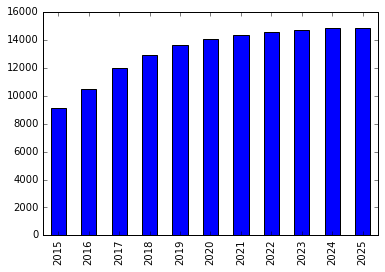

In [25]:
# Plot inactive customers over time
segments.iloc[0].plot(kind='bar')

In [26]:
segments.round(0)

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,9158.0,10517.0,11983.0,12956.0,13609.0,14060.0,14369.0,14580.0,14726.0,14826.0,14894.0
active low value,4562.0,3467.0,2906.0,2503.0,2229.0,2043.0,1917.0,1831.0,1772.0,1732.0,1705.0
cold,1903.0,2079.0,1592.0,1276.0,1078.0,939.0,844.0,779.0,734.0,704.0,683.0
warm low value,1723.0,1852.0,1407.0,1180.0,1016.0,905.0,829.0,778.0,743.0,719.0,703.0
warm high value,836.0,81.0,146.0,133.0,128.0,124.0,120.0,117.0,115.0,113.0,112.0
active high value,235.0,421.0,383.0,369.0,356.0,346.0,338.0,332.0,327.0,323.0,320.0


# Project Future Revenues 

In [27]:
revenue = {}
for segment in (customers_2015['segment'].unique()):
    revenue[str(segment)] = mean(customers_2015['amount'].ix[customers_2015.segment == str(segment)])   

In [28]:
revenue

{'active high value': 253.678730586067,
 'active low value': 38.80261224023298,
 'cold': 51.73989327634195,
 'inactive': 48.11277078684079,
 'warm high value': 314.88386119554207,
 'warm low value': 36.10272295909707}

In [29]:
customers_2015['segment'].unique()

array(['inactive', 'active low value', 'cold', 'warm low value',
       'warm high value', 'active high value'], dtype=object)

In [30]:
# --- COMPUTE THE (DISCOUNTED) CLV OF A DATABASE -----------


# Yearly revenue per segment
# only include 'active high value', 'active low value', 'active'
yearly_revenue = pd.Series([0, 38.80, 0, 0,0, 253.6], index=customers_2015['segment'].unique())

# Compute revenue per segment
revenue_per_segment = segments.multiply(yearly_revenue, axis='index')
print(revenue_per_segment)

                       2015           2016           2017          2018  \
inactive                0.0       0.000000       0.000000      0.000000   
active low value   177005.6  134506.969317  112758.786444  97116.602203   
cold                    0.0       0.000000       0.000000      0.000000   
warm low value          0.0       0.000000       0.000000      0.000000   
warm high value         0.0       0.000000       0.000000      0.000000   
active high value   59596.0  106730.109770   97020.626671  93654.240931   

                           2019          2020          2021          2022  \
inactive               0.000000      0.000000      0.000000      0.000000   
active low value   86502.683989  79286.578622  74375.449997  71033.299983   
cold                   0.000000      0.000000      0.000000      0.000000   
warm low value         0.000000      0.000000      0.000000      0.000000   
warm high value        0.000000      0.000000      0.000000      0.000000   
active high 

2015    236602.0
2016    241237.0
2017    209779.0
2018    190771.0
2019    176889.0
2020    167091.0
2021    160118.0
2022    155152.0
2023    151610.0
2024    149079.0
2025    147269.0
dtype: float64


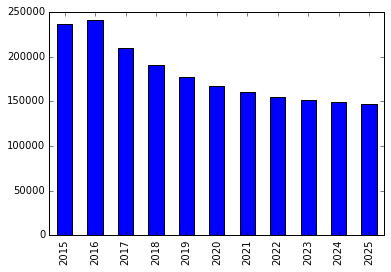

In [31]:
# Compute yearly revenue
yearly_revenue = revenue_per_segment.sum(axis=0)
print(yearly_revenue.round(0))
yearly_revenue.plot(kind='bar')

2015     236602.0
2016     477839.0
2017     687618.0
2018     878389.0
2019    1055278.0
2020    1222369.0
2021    1382488.0
2022    1537640.0
2023    1689250.0
2024    1838329.0
2025    1985598.0
dtype: float64


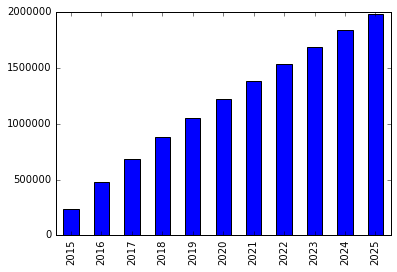

In [32]:
# Compute cumulated revenue
cumulated_revenue = yearly_revenue.cumsum(axis=0)
print(cumulated_revenue.round(0))
cumulated_revenue.plot(kind='bar')

In [33]:
# Create a discount factor
discount_rate = 0.10
discount = 1 / ((1 + discount_rate) ** np.arange(0,11))
# print(discount)

2015    236602.0
2016    219306.0
2017    173371.0
2018    143329.0
2019    120818.0
2020    103750.0
2021     90383.0
2022     79618.0
2023     70727.0
2024     63224.0
2025     56779.0
dtype: float64


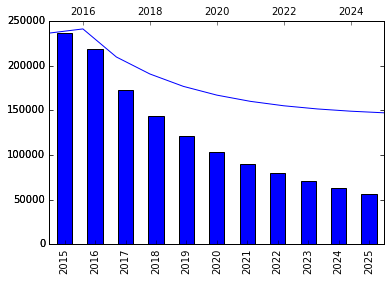

In [34]:
# Compute discounted yearly revenue
disc_yearly_revenue = yearly_revenue.multiply(discount)
print(disc_yearly_revenue.round(0))
ax1 = disc_yearly_revenue.plot(kind='bar')
ax2 = ax1.twiny()
yearly_revenue.plot(kind='line', ax=ax2)

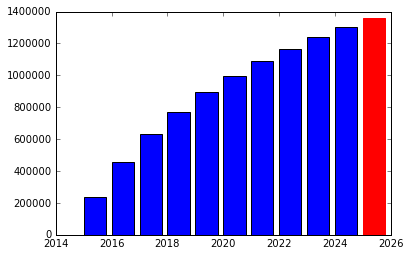

In [35]:
disc_cumulated_revenue = disc_yearly_revenue.cumsum(axis=0)
dcr = plt.bar(range(2015,2026),disc_cumulated_revenue.values)
dcr[10].set_color('r')
plt.show()

In [36]:
# What is the database worth?
print('The database is worth ${} in 10 years'.format(round(disc_cumulated_revenue[2025] - yearly_revenue[2015]),3))


The database is worth $1121305.0 in 10 years
